# Feature Discovery & Extraction Experiement

The purpose of this experiement is to explore the URL dataset and attempt to find significant, useful features to attach to the dataset for training our ML models.

The 1st identified type of features that will be explored is Lexical-based features: These are based on characteristics of the makeup of the URL strings themselves.

Examples would be: 
- Length of URL
- How many sub-domains
- Length of Top Level Domain (TLD)
<br/>... etc

Firstly, the data for Benign and Malicious classed URLs will be joined into 1 dataset:

In [31]:
URLS_LOC = '/Users/chrismclearnon/Developer/QUB-CSC3032-FYP/src/data/lexical/lexical_urls.csv'
FULL_DATASET_LOC = '/Users/chrismclearnon/Developer/QUB-CSC3032-FYP/src/data/lexical/lexical_full_featureset.csv'

X_TRAIN_DATAFRAME_LOC = '/Users/chrismclearnon/Developer/QUB-CSC3032-FYP/src/data/lexical/X_train_dataframe.csv'
X_TEST_DATAFRAME_LOC = '/Users/chrismclearnon/Developer/QUB-CSC3032-FYP/src/data/lexical/X_test_dataframe.csv'
X_TRAIN_NPZ_LOC = '/Users/chrismclearnon/Developer/QUB-CSC3032-FYP/src/data/lexical/x_train.npz'
X_TEST_NPZ_LOC = '/Users/chrismclearnon/Developer/QUB-CSC3032-FYP/src/data/lexical/x_test.npz'

Y_TRAIN_LOC = '/Users/chrismclearnon/Developer/QUB-CSC3032-FYP/src/data/lexical/y_train.csv'
Y_TEST_LOC = '/Users/chrismclearnon/Developer/QUB-CSC3032-FYP/src/data/lexical/y_test.csv'

BASE_SVC_LOC = '/Users/chrismclearnon/Developer/QUB-CSC3032-FYP/src/ml-demo-app/api/ml/models/lexical/base_svc_model.json'
BAYESIAN_SVC_LOC = '/Users/chrismclearnon/Developer/QUB-CSC3032-FYP/src/ml-demo-app/api/ml/models/lexical/bayesian_svc_model.json'
KNN_MODEL_LOC = '/Users/chrismclearnon/Developer/QUB-CSC3032-FYP/src/ml-demo-app/api/ml/models/lexical/bayesian_knn_model.json'

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.feature_selection import SelectKBest, f_classif, chi2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, plot_roc_curve, average_precision_score

from featureprocessing import FeatureEngineering as fe
from datacleaning import URLDataCleaning as ucl

from sklearn.datasets import load_iris

In [33]:
import pandas as pd

df_benign = pd.read_csv('/Users/chrismclearnon/Developer/QUB-CSC3032-FYP/src/data/Malicious-DS/URL/Benign_list_big_final.csv')
df_benign["URLType"] = "Benign"

df_malicious = pd.read_csv('/Users/chrismclearnon/Developer/QUB-CSC3032-FYP/src/data/Malicious-DS/URL/Malware_dataset.csv')
df_malicious["URLType"] = "Malicious"

dfs = [df_benign, df_malicious]
base_df = pd.concat(dfs)
base_df.reset_index(drop=True, inplace=True)
base_df = base_df.sample(frac=1).reset_index(drop=True)

display(base_df)

URL    URLType
0      http://torcache.net/torrent/F29D7CAC3AD8103807...     Benign
1      http://motthegioi.vn/quoc-te/soc-ukraine-de-ch...     Benign
2      http://mic.com/articles/117050/baltimore-polic...     Benign
3      http://5121188.com/yiyuanxiangguan/gongyishiye...  Malicious
4      http://serverfault.com/questions/479694/window...     Benign
...                                                  ...        ...
46939  http://otomoto.pl/oferta/dacia-logan-spalanie-...     Benign
46940  http://qz.com/381918/it-has-been-one-year-sinc...     Benign
46941  http://torcache.net/torrent/6F8850C2712F45EBE2...     Benign
46942  http://9779.info/%E5%B9%BC%E5%84%BF%E5%9B%AD%E...  Malicious
46943  http://xhamster.com/movies/3869409/time_for_yo...     Benign

[46944 rows x 2 columns]

Next, the classes Benign/Malicious will be label encoded, prepping them so that they can be used by ML models:
- Benign | 0
- Malicious | 1

This will be saved as the base dataset that can be built upon with whatever features to be experimented with:

In [34]:
enc = preprocessing.LabelEncoder()
base_df["URLType"] = enc.fit_transform(base_df.URLType.values)
base_df.to_csv(URLS_LOC, index=False)

Below is a function defined to extract all of the lexical features that we want to experiment with. 

In [35]:
import urllib.parse
import whois
import re
from tld import get_tld, is_tld
from urllib.parse import urlparse

def clean_data(url):
    url_obj = urlparse(url)
    if not url_obj.scheme:
        url = "http://" + url
        return url
    return url

def lexical_extract(url):
    """
    Extract lexical based features from the URL strings in the dataset. These features include:
    - Length of URL
    - Length of Hostname
    - Path length
    - TLD Length
    - Special Char Count
    - '.-@%=?' Char Count
    - Digit Count
    - Unique Char Count"""

    if not url:
        return

    url_dt = {}

    url_len = len(url)
    url_dt.update({"URLLength": url_len})

    url_rg = '(?:http.*://)?(?P<host>[^:/ ]+).*'
    url_search = re.search(url_rg, url)
    host_len = len(url_search.group('host'))
    url_dt.update({"HostLength": host_len})

    parsed_tld = get_tld(url, fix_protocol=True, fail_silently=True)
    if parsed_tld is None:
        url_dt.update({"TLDLength": 0})
    else:
        tld_len = len(parsed_tld)
        url_dt.update({"TLDLength": tld_len})

    dot_count = str(url).count('.')
    url_dt.update({"DotCount": dot_count})

    dash_count = str(url).count('-')
    url_dt.update({"DashCount": dash_count})

    at_count = str(url).count('@')
    url_dt.update({"AtSymbolCount": at_count})

    percent_count = str(url).count('%')
    url_dt.update({"PercentSymbolCount": percent_count})

    equals_count = str(url).count('=')
    url_dt.update({"EqualsSymbolCount": equals_count})

    question_mark_count = str(url).count('?')
    url_dt.update({"QuestionMarkCount": question_mark_count})

    d_count = sum(list(map(lambda x:1 if x.isdigit() else 0, list(url))))
    url_dt.update({"DigitCount": d_count})

    un_ch_count = len(set(url))
    url_dt.update({"UniqueCharCount": un_ch_count})

    return url_dt

In [65]:
feature_list = []
for index, row in base_df.iterrows():
    row["URL"] = clean_data(row["URL"])
    feature_dict = lexical_extract(row["URL"])
    feature_dict.update({"URLType": row["URLType"]})
    feature_list.append(feature_dict)

features_df = pd.DataFrame(feature_list)
display(features_df)

features_df.to_csv(FULL_DATASET_LOC, index=False)

URLLength  HostLength  TLDLength  DotCount  DashCount  AtSymbolCount  \
0            138          12          3        10          0              0   
1            103          13          2         2         14              0   
2            113           7          3         1         12              0   
3             64          11          3         2          0              0   
4            113          15          3         1         12              0   
...          ...         ...        ...       ...        ...            ...   
46939         88          10          2         2          9              0   
46940         94           6          3         1         13              0   
46941        136          12          3         9          0              0   
46942         99           9          4         1          0              0   
46943         91          12          3         2          0              0   

       PercentSymbolCount  EqualsSymbolCount  QuestionMarkCount  DigitCount  \
0                       0                  1                  1          32   
1                       0                  0                  0           6   
2                       0                  0                  0           6   
3                       0                  0                  0          18   
4                       0                  0                  0           6   
...                   ...                ...                ...         ...   
46939                   0                  0                  0           4   
46940                   0                  0                  0           9   
46941                   0                  1                  1          33   
46942                  27                  0                  0          33   
46943                   0                  1                  1           8   

       UniqueCharCount  URLType  
0                   39        0  
1                   27        0  
2                   30        0  
3                   26        1  
4                   28        0  
...                ...      ...  
46939               33        0  
46940               30        0  
46941               42        0  
46942               25        1  
46943               35        0  

[46944 rows x 12 columns]

## Feature Transformation

A scaler must be applied to the feature set in order to scale the data values for model ingestion. For initial models, we will use the MinMaxScaler transformer from sklearn. 

In [37]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler

class LexicalFeatureScaler(BaseEstimator, TransformerMixin):
    def __init__(self, scaler=MinMaxScaler):
        self.scaler = scaler

    def fit(self, X, *_):
        self.scaler = self.scaler()
        self.scaler.fit(X)
        return self

    def transform(self, X, *_):
        scaled = self.scaler.transform(X)
        return scaled

In [38]:
from sklearn.model_selection import train_test_split

x = features_df.drop(['URLType'], axis=1)
y = features_df['URLType']

X_train, x_test, Y_train, y_test = train_test_split(x, y, test_size = 0.33, random_state = 42)
X_train.to_csv(X_TRAIN_DATAFRAME_LOC, index=False)
x_test.to_csv(X_TEST_DATAFRAME_LOC, index=False)

scaler=LexicalFeatureScaler()
scaler.fit(X_train, Y_train)
X_train = scaler.transform(X_train)
x_test = scaler.transform(x_test)

from numpy import savez_compressed

savez_compressed(X_TRAIN_NPZ_LOC, X_train)
savez_compressed(X_TEST_NPZ_LOC, x_test)

Y_train.to_csv(Y_TRAIN_LOC, header=None)
y_test.to_csv(Y_TEST_LOC, header=None)

/Users/chrismclearnon/miniconda3/envs/proj-env/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
/Users/chrismclearnon/miniconda3/envs/proj-env/lib/python3.7/site-packages/ipykernel_launcher.py:21: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.


In [40]:

def tn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 0]
def fp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 1]
def fn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 0]
def tp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 1]

def tnr(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    rate = (tn/(tn+fp))
    return rate

def tpr(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    rate = (tp/(tp+fn))
    return rate

def fnr(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    rate = (fn/(fn+tp))
    return rate

def fpr(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    rate = (fp/(fp+tn))
    return rate

scoring = {'tp': make_scorer(tp),
           'tn': make_scorer(tn),
           'fp': make_scorer(fp),
           'fn': make_scorer(fn),
           'tpr': make_scorer(tpr),
           'tnr': make_scorer(tnr),
           'fpr': make_scorer(fpr),
           'fnr': make_scorer(fnr),
}

## Base SVC Model

In [78]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, make_scorer

model = SVC(probability=True)
cv = KFold(n_splits=10, shuffle=True, random_state=1)

scores = cross_validate(model, X_train, Y_train, scoring=scoring, cv=cv, n_jobs=-1)

start_time = time.time()
model.fit(X_train, Y_train)
print("--- %s seconds ---" % (time.time() - start_time))

def get_avg_stats(stat):
    total = 0
    for item in stat:
        total += item
    
    avg = (total/stat.size)
    return avg

print("TP: {}\nRate: {}\n\nTN: {}\nRate: {}\n\nFP: {}\nRate: {}\n\nFN: {}\nRate: {}\n".format(
    get_avg_stats(scores["test_tp"]),
    get_avg_stats(scores["test_tpr"]),
    get_avg_stats(scores["test_tn"]),
    get_avg_stats(scores["test_tnr"]),
    get_avg_stats(scores["test_fp"]),
    get_avg_stats(scores["test_fpr"]),
    get_avg_stats(scores["test_fn"]),
    get_avg_stats(scores["test_fnr"]),
))

--- 65.39766693115234 seconds ---
TP: 684.1
Rate: 0.8831979624526115

TN: 2344.8
Rate: 0.989075073696324

FP: 25.9
Rate: 0.010924926303676015

FN: 90.4
Rate: 0.1168020375473885



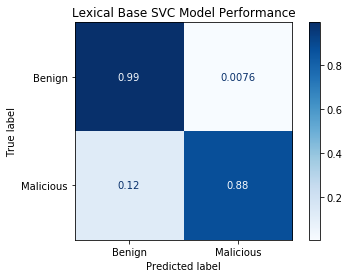

'Base SVC() Accuracy Score: 0.9634650142008778'

In [88]:
import matplotlib.pyplot as plt

y_pred=model.predict(x_test)

from sklearn.metrics import plot_confusion_matrix
disp = plot_confusion_matrix(model, x_test, y_test,
                                 display_labels=['Benign', 'Malicious'],
                                 cmap=plt.cm.Blues,
                                 normalize='true')
disp.ax_.set_title('Lexical Base SVC Model Performance')
plt.show()
display(f'Base SVC() Accuracy Score: {accuracy_score(y_test, y_pred, normalize=True)}')

# from sklearn.metrics import plot_confusion_matrix
# disp = plot_confusion_matrix(model, x_test, y_test,
#                                  display_labels=['Benign', 'Malicious'],
#                                  cmap=plt.cm.Blues,
#                                  normalize='true')
# disp.ax_.set_title('Lexical Trained Model Performance')
# plt.show()

## Bayesian Optimisation

Now that a base SVM classifier performance has been established, the hyperparameters of the SVM model need to be tweaked or altered in some way such that 

In [46]:
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.model_selection import train_test_split

svc_search = {
    'C': Real(0.01, 100.0, prior='log-uniform'),
    'gamma': Real(1e-6, 1e+1, prior='log-uniform'),
    'kernel': Categorical(['poly', 'rbf']),
    'degree': Integer(1,8),
}

searchcv = BayesSearchCV(
    SVC(probability=True),
    search_spaces = svc_search,
    n_iter=10,
    cv=cv,
    verbose=5,
    n_jobs=4
)

def on_step(optim_result):
    score = searchcv.best_score_
    print(f'Best score: {score}')

    
import time
start_time = time.time()
searchcv.fit(X_train, Y_train, callback=on_step)
print("--- %s seconds ---" % (time.time() - start_time))

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   6 out of  10 | elapsed: 11.3min remaining:  7.6min
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed: 14.7min finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Best score: 0.7537517486964262
Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=4)]: Done   6 out of  10 | elapsed:  9.1min remaining:  6.0min
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed: 11.1min finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Best score: 0.7537517486964262
Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=4)]: Done   6 out of  10 | elapsed:  9.4min remaining:  6.2min
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed: 11.7min finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Best score: 0.9106257153758107
Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=4)]: Done   6 out of  10 | elapsed: 12.0min remaining:  8.0min
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed: 15.5min finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Best score: 0.9106257153758107
Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=4)]: Done   6 out of  10 | elapsed:  5.2min remaining:  3.4min
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:  6.8min finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Best score: 0.9396858705328754
Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=4)]: Done   6 out of  10 | elapsed: 11.3min remaining:  7.5min
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed: 13.6min finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Best score: 0.9396858705328754
Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=4)]: Done   6 out of  10 | elapsed:  8.5min remaining:  5.7min
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed: 10.8min finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Best score: 0.9396858705328754
Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=4)]: Done   6 out of  10 | elapsed: 12.4min remaining:  8.2min


Best score: 0.9396858705328754
Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed: 20.9min finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   6 out of  10 | elapsed: 13.0min remaining:  8.7min
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed: 15.8min finished


Best score: 0.9396858705328754
Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   6 out of  10 | elapsed: 13.4min remaining:  8.9min
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed: 16.5min finished


Best score: 0.9396858705328754
--- 8323.800348043442 seconds ---


In [86]:
import json
import collections
import scipy

def isnamedtuple(obj):
    """Heuristic check if an object is a namedtuple."""
    return isinstance(obj, tuple) \
           and hasattr(obj, "_fields") \
           and hasattr(obj, "_asdict") \
           and callable(obj._asdict)
        
def serialize(data):
    if data is None or isinstance(data, (bool, int, float, str)):
        return data
    if isinstance(data, list):
        return [serialize(val) for val in data]
    if isinstance(data, collections.OrderedDict):
        return {"py/collections.OrderedDict":
                [[serialize(k), serialize(v)] for k, v in data.iteritems()]}
    if isnamedtuple(data):
        return {"py/collections.namedtuple": {
            "type":   type(data).__name__,
            "fields": list(data._fields),
            "values": [serialize(getattr(data, f)) for f in data._fields]}}
    if isinstance(data, dict):
        if all(isinstance(k, str) for k in data):
            return {k: serialize(v) for k, v in data.items()}
        return {"py/dict": [[serialize(k), serialize(v)] for k, v in data.items()]}
    if isinstance(data, tuple):
        return {"py/tuple": [serialize(val) for val in data]}
    if isinstance(data, set):
        return {"py/set": [serialize(val) for val in data]}
    if isinstance(data, np.ndarray):
        return {"py/numpy.ndarray": {
            "values": data.tolist(),
            "dtype":  str(data.dtype)}}
    if isinstance(data, scipy.sparse.csr.csr_matrix):
        data = data.toarray()
        return {"py/scipy.csr_matrix": {
            "values": data.tolist(),
            "dtype":  str(data.dtype)}}
#     if isinstance(data, OneHotEncoder):
#         return
    raise TypeError("Type %s not data-serializable" % type(data))
    
    
def restore(dct):
    if "py/dict" in dct:
        return dict(dct["py/dict"])
    if "py/tuple" in dct:
        return tuple(dct["py/tuple"])
    if "py/set" in dct:
        return set(dct["py/set"])
    if "py/collections.namedtuple" in dct:
        data = dct["py/collections.namedtuple"]
        return namedtuple(data["type"], data["fields"])(*data["values"])
    if "py/numpy.ndarray" in dct:
        data = dct["py/numpy.ndarray"]
        return np.array(data["values"], dtype=data["dtype"])
    if "py/collections.OrderedDict" in dct:
        return OrderedDict(dct["py/collections.OrderedDict"])
    if "py/scipy.csr_matrix" in dct:
        data = dct["py/scipy.csr_matrix"]
        arr =  np.array(data["values"], dtype=data["dtype"])
        return sparse.csr_matrix(arr)
    if "py/sklearn.preprocessing._encoders.OneHotEncoder" in dct:
        attr = dct["py/sklearn.preprocessing._encoders.OneHotEncoder"]
        return deserialize(SVC(), attr)
    return dct
    
def data_to_json(data, location):
    attr_json = serialize(data)
    with open(location, "w") as write_file:
        json.dump(attr_json, write_file)
    return json.dumps(attr_json, indent=4)

def json_to_data(s, file):
    with open(file, "r") as read_file:
        attr_data = json.load(read_file, object_hook=restore)
        return attr_data

def deserialize(estim, attr):
    for k, v in attr.items():
        setattr(estim, k, v)
    return estim

TPR: 0.8026694582570008
TNR: 0.9828635078399451
FPR: 0.017136492160054837
FNR: 0.19733054174299922
Optimised SVC() Accuracy Score: 0.9384198295894656
Best params found: {'C': 0.23495091579540903, 'degree': 3, 'gamma': 7.848311004980298, 'kernel': 'poly'}


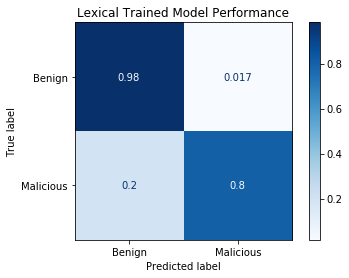

'{\n    "decision_function_shape": "ovr",\n    "break_ties": false,\n    "kernel": "poly",\n    "degree": 3,\n    "gamma": 7.848311004980298,\n    "coef0": 0.0,\n    "tol": 0.001,\n    "C": 0.23495091579540903,\n    "nu": 0.0,\n    "epsilon": 0.0,\n    "shrinking": true,\n    "probability": true,\n    "cache_size": 200,\n    "class_weight": null,\n    "verbose": false,\n    "max_iter": -1,\n    "random_state": null,\n    "_sparse": false,\n    "class_weight_": {\n        "py/numpy.ndarray": {\n            "values": [\n                1.0,\n                1.0\n            ],\n            "dtype": "float64"\n        }\n    },\n    "classes_": {\n        "py/numpy.ndarray": {\n            "values": [\n                0,\n                1\n            ],\n            "dtype": "int64"\n        }\n    },\n    "_gamma": 7.848311004980298,\n    "support_": {\n        "py/numpy.ndarray": {\n            "values": [\n                4,\n                8,\n                24,\n                3

In [68]:
y_pred = searchcv.predict(x_test)
print(f'TPR: {tpr(y_test, y_pred)}\nTNR: {tnr(y_test, y_pred)}\nFPR: {fpr(y_test, y_pred)}\nFNR: {fnr(y_test, y_pred)}')
print(f'Optimised SVC() Accuracy Score: {accuracy_score(y_test, y_pred)}')
print(f'Best params found: {searchcv.best_params_}')

disp = plot_confusion_matrix(searchcv.best_estimator_, x_test, y_test,
                                 display_labels=['Benign', 'Malicious'],
                                 cmap=plt.cm.Blues,
                                 normalize='true')
disp.ax_.set_title('Lexical Trained Model Performance')
plt.show()

data_to_json(model.__dict__, BASE_SVC_LOC)
data_to_json(searchcv.best_estimator_.__dict__, BAYESIAN_SVC_LOC)

In [69]:
metrics = ['mean_test_score', 'mean_fit_time', 'param_C', 'param_gamma', 'param_kernel', 'param_degree']

print('Optimised SVC() BayesianSearchCV Metrics Results\n\n')
idx = 0
for _ in searchcv.cv_results_['params']:
    print(f'===Iteration {idx+1}===')
    for metric in metrics:
        print(f'- {metric}: {searchcv.cv_results_[metric][idx]}')
    idx+=1
    print('\n\n')

Optimised SVC() BayesianSearchCV Metrics Results


===Iteration 1===
- mean_test_score: 0.7537517486964262
- mean_fit_time: 310.8129739999771
- param_C: 0.04650641180721131
- param_gamma: 0.002793995927587629
- param_kernel: rbf
- param_degree: 6



===Iteration 2===
- mean_test_score: 0.7537517486964262
- mean_fit_time: 240.91544225215912
- param_C: 3.399694880386022
- param_gamma: 0.00040004175636649696
- param_kernel: poly
- param_degree: 3



===Iteration 3===
- mean_test_score: 0.9106257153758107
- mean_fit_time: 251.1515272140503
- param_C: 5.388781793476112
- param_gamma: 0.14412710977451254
- param_kernel: rbf
- param_degree: 4



===Iteration 4===
- mean_test_score: 0.7537517486964262
- mean_fit_time: 329.10392994880675
- param_C: 0.01296083397957329
- param_gamma: 0.0115342388638109
- param_kernel: rbf
- param_degree: 8



===Iteration 5===
- mean_test_score: 0.9396858705328754
- mean_fit_time: 143.06029996871948
- param_C: 0.23495091579540903
- param_gamma: 7.848311004980298

Base model AUC: 0.9806182170060692
Optimised model AUC: 0.963275804396517


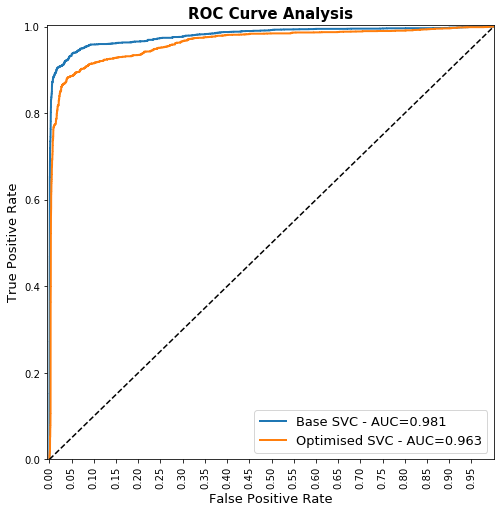

In [58]:
from sklearn.metrics import roc_curve, auc

y_scores_base = model.decision_function(x_test)
y_scores_opt = searchcv.decision_function(x_test)

fpr_base, tpr_base, auc_thresholds_base = roc_curve(y_test, y_scores_base)
fpr_bayesian, tpr_bayesian, auc_thresholds = roc_curve(y_test, y_scores_opt)
print(f'Base model AUC: {auc(fpr_base, tpr_base)}\nOptimised model AUC: {auc(fpr_bayesian, tpr_bayesian)}')

plt.figure(figsize=(8,8))
plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.plot(fpr_base, tpr_base, linewidth=2, label="Base {} - AUC={:.3f}".format(model.__class__.__name__, auc(fpr_base, tpr_base)))
plt.plot(fpr_bayesian, tpr_bayesian, linewidth=2, label="Optimised {} - AUC={:.3f}".format(searchcv.best_estimator_.__class__.__name__, auc(fpr_bayesian, tpr_bayesian)))
plt.plot([0,1], [0,1], 'k--')
plt.axis([-0.005, 1, 0, 1.005])
plt.xticks(np.arange(0, 1, step=0.05), rotation=90)
plt.xlabel("False Positive Rate", fontsize=13)
plt.ylabel("True Positive Rate", fontsize=13)
plt.legend(prop={'size':13}, loc='best')

plt.show()

In [70]:
from skopt import gp_minimize
from sklearn.model_selection import cross_val_score
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args
from sklearn.metrics import hinge_loss, make_scorer
from sklearn.svm import SVC

# Y_train = pd.read_csv('/Users/chrismclearnon/Developer/QUB-CSC3032-FYP/src/data/y_train.csv', header=None)[1]
# Y_test = pd.read_csv('/Users/chrismclearnon/Developer/QUB-CSC3032-FYP/src/data/y_test.csv', header=None)[1]
    
def custom_hinge_loss(Y_true, Y_pred):
    return (hinge_loss(Y_true, Y_pred))

scorer = make_scorer(custom_hinge_loss, greater_is_better=False, needs_threshold=True)

hinge_loss_searchcv = BayesSearchCV(
    SVC(probability=True),
    search_spaces = svc_search,
    n_iter=10,
    cv=cv,
    verbose=5,
    n_jobs=-1,
    scoring=scorer
)

def on_step(optim_result):
    score = hinge_loss_searchcv.best_score_
    print(f'Best score: {score}')

hinge_loss_searchcv.fit(X_train, Y_train, callback=on_step)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed: 13.4min remaining:  8.9min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 17.2min finished


Best score: -0.34074003484930654
Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:  6.2min remaining:  4.1min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  7.8min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Best score: -0.17197192657860244
Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:  8.6min remaining:  5.7min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 11.0min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Best score: -0.17197192657860244
Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:  9.6min remaining:  6.4min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 11.6min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Best score: -0.17197192657860244
Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:  8.4min remaining:  5.6min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 10.4min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Best score: -0.17197192657860244
Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed: 11.4min remaining:  7.6min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 15.5min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Best score: -0.17197192657860244
Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:  8.7min remaining:  5.8min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 10.5min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Best score: -0.17197192657860244
Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed: 10.4min remaining:  6.9min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 14.1min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Best score: -0.17197192657860244
Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed: 10.4min remaining:  7.0min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 13.4min finished


Best score: -0.17197192657860244
Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:  8.8min remaining:  5.9min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 11.3min finished


Best score: -0.17197192657860244


BayesSearchCV(cv=KFold(n_splits=10, random_state=1, shuffle=True),
              error_score='raise',
              estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                            class_weight=None, coef0=0.0,
                            decision_function_shape='ovr', degree=3,
                            gamma='scale', kernel='rbf', max_iter=-1,
                            probability=True, random_state=None, shrinking=True,
                            tol=0.001, verbose=False),
              fit_params=None, iid=True, n_iter=1...
              scoring=make_scorer(custom_hinge_loss, greater_is_better=False, needs_threshold=True),
              search_spaces={'C': Real(low=0.01, high=100.0, prior='log-uniform', transform='identity'),
                             'degree': Integer(low=1, high=8, prior='uniform', transform='identity'),
                             'gamma': Real(low=1e-06, high=10.0, prior='log-uniform', transform='identity'),
                          

TPR: 0.7893221669719969
TNR: 0.9891183274783651
FPR: 0.01088167252163482
FNR: 0.21067783302800314
Optimised SVC() Accuracy Score: 0.9398399173767106
Best params found: {'C': 41.53192660049887, 'degree': 4, 'gamma': 2.2876141168466595, 'kernel': 'poly'}


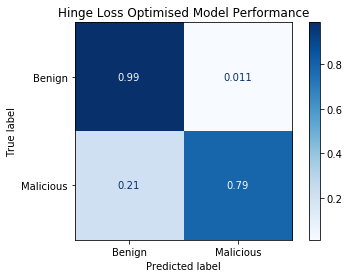

In [71]:
y_pred = hinge_loss_searchcv.predict(x_test)
print(f'TPR: {tpr(y_test, y_pred)}\nTNR: {tnr(y_test, y_pred)}\nFPR: {fpr(y_test, y_pred)}\nFNR: {fnr(y_test, y_pred)}')
print(f'Optimised SVC() Accuracy Score: {accuracy_score(y_test, y_pred)}')
print(f'Best params found: {hinge_loss_searchcv.best_params_}')

disp = plot_confusion_matrix(hinge_loss_searchcv.best_estimator_, x_test, y_test,
                                 display_labels=['Benign', 'Malicious'],
                                 cmap=plt.cm.Blues,
                                 normalize='true')
disp.ax_.set_title('Hinge Loss Optimised Model Performance')
plt.show()

In [75]:
Y_pred_decision1 = hinge_loss_searchcv.decision_function(x_test)
display(f'Standard Hinge Loss: {hinge_loss(y_test, Y_pred_decision1)}')
display(f'Scorer Function Hinge Loss: {-scorer(hinge_loss_searchcv.best_estimator_, x_test, y_test)}')

'Standard Hinge Loss: 0.1691252223871737'

'Scorer Function Hinge Loss: 0.1691252223871737'

In [76]:
print('Hinge Loss Optimised SVC() BayesianSearchCV Metrics Results\n\n')
idx = 0
for _ in hinge_loss_searchcv.cv_results_['params']:
    print(f'===Iteration {idx+1}===')
    for metric in metrics:
        print(f'- {metric}: {hinge_loss_searchcv.cv_results_[metric][idx]}')
    idx+=1
    print('\n\n')

Hinge Loss Optimised SVC() BayesianSearchCV Metrics Results


===Iteration 1===
- mean_test_score: -0.34074003484930654
- mean_fit_time: 364.46573758125305
- param_C: 3.5104733651043603
- param_gamma: 0.020353133688715264
- param_kernel: rbf
- param_degree: 2



===Iteration 2===
- mean_test_score: -0.17197192657860244
- mean_fit_time: 167.7252914905548
- param_C: 41.53192660049887
- param_gamma: 2.2876141168466595
- param_kernel: poly
- param_degree: 4



===Iteration 3===
- mean_test_score: -0.4924965026071474
- mean_fit_time: 233.2501763820648
- param_C: 0.4512022089252642
- param_gamma: 1.433862935435561e-05
- param_kernel: poly
- param_degree: 8



===Iteration 4===
- mean_test_score: -0.4924965026071474
- mean_fit_time: 253.35897047519683
- param_C: 2.4806242142003785
- param_gamma: 2.9781721674678033e-05
- param_kernel: poly
- param_degree: 6



===Iteration 5===
- mean_test_score: -0.4924965026071474
- mean_fit_time: 225.10736174583434
- param_C: 0.05012638095183492
- param_gam

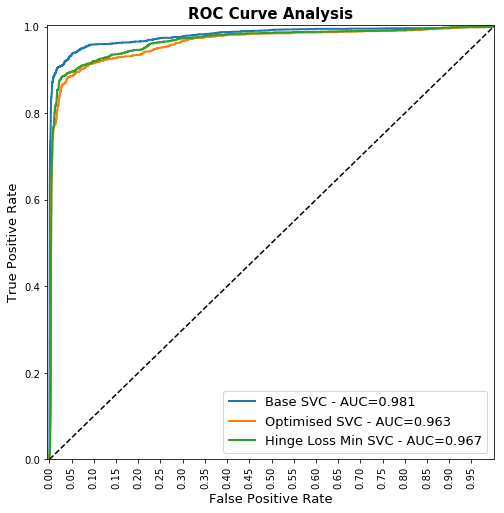

In [77]:
from sklearn.metrics import roc_curve, auc

y_scores_base = model.decision_function(x_test)
y_scores_opt = searchcv.decision_function(x_test)
y_scores_hinge_loss = hinge_loss_searchcv.decision_function(x_test)

fpr_base, tpr_base, auc_thresholds_base = roc_curve(y_test, y_scores_base)
fpr_bayesian, tpr_bayesian, auc_thresholds = roc_curve(y_test, y_scores_opt)
fpr_hinge, tpr_hinge, auc_thresholds_base = roc_curve(y_test, y_scores_hinge_loss)

plt.figure(figsize=(8,8))
plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.plot(fpr_base, tpr_base, linewidth=2, label="Base {} - AUC={:.3f}".format(model.__class__.__name__, auc(fpr_base, tpr_base)))
plt.plot(fpr_bayesian, tpr_bayesian, linewidth=2, label="Optimised {} - AUC={:.3f}".format(searchcv.best_estimator_.__class__.__name__, auc(fpr_bayesian, tpr_bayesian)))
plt.plot(fpr_hinge, tpr_hinge, linewidth=2, label="Hinge Loss Min {} - AUC={:.3f}".format(hinge_loss_searchcv.best_estimator_.__class__.__name__, auc(fpr_hinge, tpr_hinge)))
plt.plot([0,1], [0,1], 'k--')
plt.axis([-0.005, 1, 0, 1.005])
plt.xticks(np.arange(0, 1, step=0.05), rotation=90)
plt.xlabel("False Positive Rate", fontsize=13)
plt.ylabel("True Positive Rate", fontsize=13)
plt.legend(prop={'size':13}, loc='best')

plt.show()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import KFold
from skopt import BayesSearchCV
from sklearn.model_selection import GridSearchCV

import scipy.sparse

X_train = scipy.sparse.load_npz(X_TRAIN_CSR_LOC)
Y_train = pd.read_csv(Y_TRAIN_LOC, header=None)[1]
X_test = scipy.sparse.load_npz(X_TEST_CSR_LOC)
Y_test = pd.read_csv(Y_TEST_LOC, header=None)[1]

base_knn = KNeighborsClassifier()
base_knn.fit(X_train, Y_train)
display(base_knn.score(X_test, Y_test))

cv = KFold(n_splits=10, shuffle=True, random_state=1)

knn_search_space = {
    'leaf_size': list(range(1, 50)),
    'n_neighbors': list(range(1, 30)),
    'p': [1, 2]
}

knn_searchcv = BayesSearchCV(
    estimator=KNeighborsClassifier(),
    search_spaces = knn_search_space,
    cv=cv,
    verbose=5,
    n_jobs=-1
)

def on_step(optim_result):
    score = knn_searchcv.best_score_
    print(f'Best score: {score}')
    if score >= 0.98:
        print('Interrupting!')
        return True

    
import time
start_time = time.time()

knn_searchcv.fit(X_train, Y_train)
print("--- %s seconds ---" % (time.time() - start_time))

display(knn_searchcv.score(X_test, Y_test))
data_to_json(knn_searchcv.best_estimator_.__dict__, KNN_MODEL_LOC)

In [ ]:
Y_pred_decision1 = knn_searchcv.decision_function(X_test)
display(f'Standard Hinge Loss: {hinge_loss(Y_test, Y_pred_decision)}')
display(f'Scorer Function Hinge Loss: {scorer(searchcv.best_estimator_, X_test, Y_test)}')

The 1st experiment for feature selection will use Chi-Squared analysis of the feature set, to select a specified number of features that have the highest correlation with the class set:

![title](img/ChiSquared.png)<br/><br/>

For a base test, we will select the top 5 features from the dataset:

In [59]:
chi_selector = SelectKBest(chi2, k=5)
chi_fit = chi_selector.fit(x, y)

np.set_printoptions(precision=4, suppress=True)
i = 0
for col in x.columns:
    print("{} - {:.3f}".format(col, chi_fit.scores_[i]))
    i+=1

chi_x = chi_fit.transform(x)
display(chi_x)

URLLength - 78915.344
HostLength - 1684.745
TLDLength - 595.874
DotCount - 445.415
DashCount - 52358.421
AtSymbolCount - 41.561
PercentSymbolCount - 13135.528
EqualsSymbolCount - 913.961
QuestionMarkCount - 35.067
DigitCount - 559.712
UniqueCharCount - 4680.189


array([[138,  12,   0,   0,  39],
       [103,  13,  14,   0,  27],
       [113,   7,  12,   0,  30],
       ...,
       [136,  12,   0,   0,  42],
       [ 99,   9,   0,  27,  25],
       [ 91,  12,   0,   0,  35]])

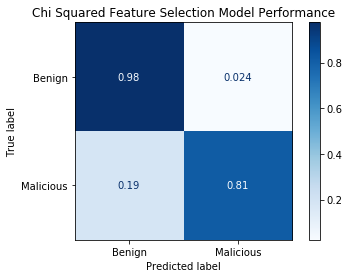

In [60]:
X_train_chi, x_test_chi, Y_train_chi, y_test_chi = train_test_split(chi_x, y, test_size = 0.33, random_state = 42)

chi_scaler=LexicalFeatureScaler()
chi_scaler.fit(X_train_chi, Y_train_chi)
X_train_chi = chi_scaler.transform(X_train_chi)
x_test_chi = chi_scaler.transform(x_test_chi)

chi_base_model = SVC()
chi_base_model.fit(X_train_chi, Y_train_chi)
y_pred_chi = chi_base_model.predict(x_test_chi)

disp = plot_confusion_matrix(chi_base_model, x_test_chi, y_test_chi,
                                 display_labels=['Benign', 'Malicious'],
                                 cmap=plt.cm.Blues,
                                 normalize='true')
disp.ax_.set_title('Chi Squared Feature Selection Model Performance')
plt.show()

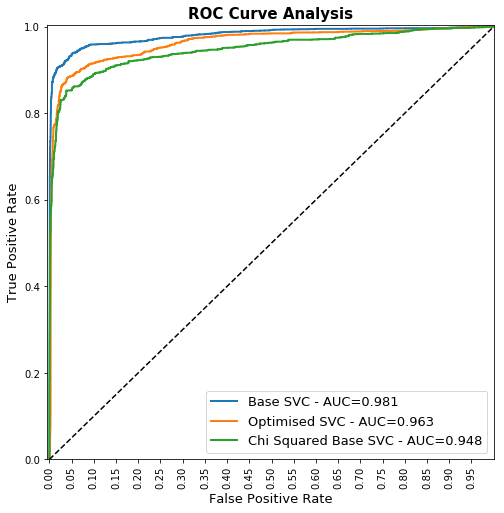

In [61]:
y_scores_chi = chi_base_model.decision_function(x_test_chi)

fpr_chi, tpr_chi, auc_thresholds_chi = roc_curve(y_test_chi, y_scores_chi)

plt.figure(figsize=(8,8))
plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.plot(fpr_base, tpr_base, linewidth=2, label="Base {} - AUC={:.3f}".format(model.__class__.__name__, auc(fpr_base, tpr_base)))
plt.plot(fpr_bayesian, tpr_bayesian, linewidth=2, label="Optimised {} - AUC={:.3f}".format(searchcv.best_estimator_.__class__.__name__, auc(fpr_bayesian, tpr_bayesian)))
plt.plot(fpr_chi, tpr_chi, linewidth=2, label="Chi Squared Base {} - AUC={:.3f}".format(chi_base_model.__class__.__name__, auc(fpr_chi, tpr_chi)))
plt.plot([0,1], [0,1], 'k--')
plt.axis([-0.005, 1, 0, 1.005])
plt.xticks(np.arange(0, 1, step=0.05), rotation=90)
plt.xlabel("False Positive Rate", fontsize=13)
plt.ylabel("True Positive Rate", fontsize=13)
plt.legend(prop={'size':13}, loc='best')

In [62]:
chi_searchcv = BayesSearchCV(
    SVC(probability=True),
    search_spaces = {
        'C': Real(0.01, 100.0, prior='log-uniform'),
        'gamma': Real(1e-6, 1e+1, prior='log-uniform'),
        'kernel': Categorical(['poly', 'rbf']),
        'degree': Integer(1,8),
    },
    n_iter=10,
    cv=cv,
    verbose=5,
    n_jobs=-1
)

start_time = time.time()
chi_searchcv.fit(X_train_chi, Y_train_chi, callback=on_step)
print("--- %s seconds ---" % (time.time() - start_time))

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:  6.9min remaining:  4.6min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  8.2min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Best score: 0.9396858705328754
Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:  6.9min remaining:  4.6min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  8.5min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Best score: 0.9396858705328754
Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed: 13.3min remaining:  8.9min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 15.2min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Best score: 0.9396858705328754
Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:  5.2min remaining:  3.5min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  6.2min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Best score: 0.9396858705328754
Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:  4.2min remaining:  2.8min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  5.2min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Best score: 0.9396858705328754
Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed: 46.7min remaining: 31.2min


Best score: 0.9396858705328754
Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 64.5min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:  5.8min remaining:  3.9min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 10.5min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Best score: 0.9396858705328754
Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:  5.0min remaining:  3.3min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  6.0min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Best score: 0.9396858705328754
Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:  6.8min remaining:  4.5min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  8.5min finished


Best score: 0.9396858705328754
Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:  8.5min remaining:  5.7min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 10.6min finished


Best score: 0.9396858705328754
--- 8683.772334098816 seconds ---


In [63]:
y_pred_bayesian_chi = chi_searchcv.predict(x_test_chi)
print(f'TPR: {tpr(y_test_chi, y_pred_bayesian_chi)}\nTNR: {tnr(y_test_chi, y_pred_bayesian_chi)}\nFPR: {fpr(y_test_chi, y_pred_bayesian_chi)}\nFNR: {fnr(y_test_chi, y_pred_bayesian_chi)}')
print(f'Best params found: {chi_searchcv.best_params_}')

chi_bayesian_model_loc='/Users/chrismclearnon/Developer/QUB-CSC3032-FYP/src/ml-demo-app/api/ml/models/lexical/chi_bayesian_svc_model.json'
data_to_json(chi_searchcv.best_estimator_.__dict__, chi_bayesian_model_loc)

TPR: 0.7840879350955248
TNR: 0.9674406648958959
FPR: 0.03255933510410419
FNR: 0.21591206490447526
Best params found: {'C': 27.331868055590828, 'degree': 1, 'gamma': 0.7729624685309266, 'kernel': 'rbf'}


'{\n    "decision_function_shape": "ovr",\n    "break_ties": false,\n    "kernel": "rbf",\n    "degree": 1,\n    "gamma": 0.7729624685309266,\n    "coef0": 0.0,\n    "tol": 0.001,\n    "C": 27.331868055590828,\n    "nu": 0.0,\n    "epsilon": 0.0,\n    "shrinking": true,\n    "probability": true,\n    "cache_size": 200,\n    "class_weight": null,\n    "verbose": false,\n    "max_iter": -1,\n    "random_state": null,\n    "_sparse": false,\n    "class_weight_": {\n        "py/numpy.ndarray": {\n            "values": [\n                1.0,\n                1.0\n            ],\n            "dtype": "float64"\n        }\n    },\n    "classes_": {\n        "py/numpy.ndarray": {\n            "values": [\n                0,\n                1\n            ],\n            "dtype": "int64"\n        }\n    },\n    "_gamma": 0.7729624685309266,\n    "support_": {\n        "py/numpy.ndarray": {\n            "values": [\n                4,\n                14,\n                19,\n                

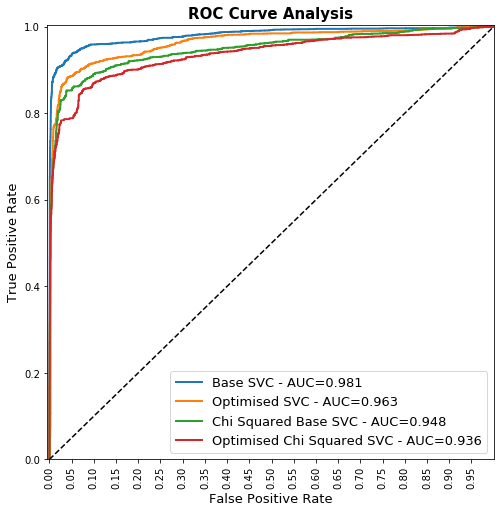

In [64]:
y_scores_bayesian_chi = chi_searchcv.best_estimator_.decision_function(x_test_chi)

fpr_bayesian_chi, tpr_bayesian_chi, auc_thresholds_bayesian_chi = roc_curve(y_test_chi, y_scores_bayesian_chi)

plt.figure(figsize=(8,8))
plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.plot(fpr_base, tpr_base, linewidth=2, label="Base {} - AUC={:.3f}".format(model.__class__.__name__, auc(fpr_base, tpr_base)))
plt.plot(fpr_bayesian, tpr_bayesian, linewidth=2, label="Optimised {} - AUC={:.3f}".format(searchcv.best_estimator_.__class__.__name__, auc(fpr_bayesian, tpr_bayesian)))
plt.plot(fpr_chi, tpr_chi, linewidth=2, label="Chi Squared Base {} - AUC={:.3f}".format(chi_base_model.__class__.__name__, auc(fpr_chi, tpr_chi)))
plt.plot(fpr_bayesian_chi, tpr_bayesian_chi, linewidth=2, label="Optimised Chi Squared {} - AUC={:.3f}".format(chi_searchcv.best_estimator_.__class__.__name__, auc(fpr_bayesian_chi, tpr_bayesian_chi)))
plt.plot([0,1], [0,1], 'k--')
plt.axis([-0.005, 1, 0, 1.005])
plt.xticks(np.arange(0, 1, step=0.05), rotation=90)
plt.xlabel("False Positive Rate", fontsize=13)
plt.ylabel("True Positive Rate", fontsize=13)
plt.legend(prop={'size':13}, loc='best')

It can be observed from the plot above that whenever the Chi Squared statistical analysis is applied to the dataset, and the top 5 features are selected:<br/>
- Increase in model prediction accuracy for a default SVM classifier
- Improved AUC for Receiver Operating Characteristic (ROC)

In [80]:
from sklearn.neighbors import KNeighborsClassifier

base_knn = KNeighborsClassifier()

knn_scores = cross_validate(base_knn, X_train, Y_train, scoring=scoring, cv=cv, n_jobs=-1)
start_time = time.time()
base_knn.fit(X_train, Y_train)
print("--- %s seconds ---" % (time.time() - start_time))

print("Base SVC() Model Average Performance Metrics\n\nTP: {}\nRate: {}\n\nTN: {}\nRate: {}\n\nFP: {}\nRate: {}\n\nFN: {}\nRate: {}\n".format(
    get_avg_stats(knn_scores["test_tp"]),
    get_avg_stats(knn_scores["test_tpr"]),
    get_avg_stats(knn_scores["test_tn"]),
    get_avg_stats(knn_scores["test_tnr"]),
    get_avg_stats(knn_scores["test_fp"]),
    get_avg_stats(knn_scores["test_fpr"]),
    get_avg_stats(knn_scores["test_fn"]),
    get_avg_stats(knn_scores["test_fnr"]),
))

--- 0.26448893547058105 seconds ---
Base SVC() Model Average Performance Metrics

TP: 747.8
Rate: 0.9654859124459725

TN: 2341.8
Rate: 0.9878169973188807

FP: 28.9
Rate: 0.012183002681119246

FN: 26.7
Rate: 0.03451408755402758



In [82]:
knn_search_space = {
    'leaf_size': list(range(1, 50)),
    'n_neighbors': list(range(1, 30)),
    'p': [1, 2]
}

knn_searchcv = BayesSearchCV(
    estimator=KNeighborsClassifier(),
    search_spaces = knn_search_space,
    cv=cv,
    verbose=5,
    n_jobs=-1
)

def on_step(optim_result):
    score = knn_searchcv.best_score_
    print(f'Best score: {score}')


start_time = time.time()
knn_searchcv.fit(X_train, Y_train, callback=on_step)
print("--- %s seconds ---" % (time.time() - start_time))

# data_to_json(knn_searchcv.best_estimator_.__dict__, KNN_MODEL_LOC)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    6.1s remaining:    4.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    6.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Best score: 0.9783797532748315
Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    2.7s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Best score: 0.9823222688541269
Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    3.8s remaining:    2.6s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    4.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Best score: 0.9823222688541269
Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    4.0s remaining:    2.7s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    5.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Best score: 0.9823222688541269
Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    3.2s remaining:    2.2s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    4.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Best score: 0.9823222688541269
Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    3.0s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Best score: 0.9823222688541269
Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    2.6s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Best score: 0.9856606893043368
Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    2.4s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Best score: 0.9856606893043368
Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    2.5s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.1s finished


Best score: 0.9856606893043368
Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    2.8s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.4s finished


Best score: 0.9856606893043368
Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    2.6s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.4s finished


Best score: 0.9903026834541524


/Users/chrismclearnon/miniconda3/envs/proj-env/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    2.2s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    2.8s finished


Best score: 0.9903026834541524
Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    2.9s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.7s finished


Best score: 0.9903344779346306


/Users/chrismclearnon/miniconda3/envs/proj-env/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    2.4s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    2.9s finished


Best score: 0.9903344779346306


/Users/chrismclearnon/miniconda3/envs/proj-env/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    2.1s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    2.8s finished


Best score: 0.9903344779346306


/Users/chrismclearnon/miniconda3/envs/proj-env/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    2.0s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    2.5s finished


Best score: 0.9903344779346306


/Users/chrismclearnon/miniconda3/envs/proj-env/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    2.1s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    2.7s finished


Best score: 0.9903344779346306


/Users/chrismclearnon/miniconda3/envs/proj-env/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    2.0s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    2.6s finished


Best score: 0.9903344779346306


/Users/chrismclearnon/miniconda3/envs/proj-env/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    2.3s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    2.9s finished


Best score: 0.9903344779346306


/Users/chrismclearnon/miniconda3/envs/proj-env/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    3.8s remaining:    2.5s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    4.6s finished


Best score: 0.9903344779346306


/Users/chrismclearnon/miniconda3/envs/proj-env/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    2.8s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.3s finished


Best score: 0.9903344779346306


/Users/chrismclearnon/miniconda3/envs/proj-env/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    2.2s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    2.7s finished


Best score: 0.9903344779346306


/Users/chrismclearnon/miniconda3/envs/proj-env/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    3.1s remaining:    2.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.7s finished


Best score: 0.9903344779346306


/Users/chrismclearnon/miniconda3/envs/proj-env/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    1.9s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    2.5s finished


Best score: 0.9903344779346306


/Users/chrismclearnon/miniconda3/envs/proj-env/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    2.2s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    2.9s finished


Best score: 0.9903344779346306


/Users/chrismclearnon/miniconda3/envs/proj-env/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    3.9s remaining:    2.6s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    4.5s finished


Best score: 0.9903344779346306


/Users/chrismclearnon/miniconda3/envs/proj-env/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    3.0s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.8s finished


Best score: 0.9903344779346306


/Users/chrismclearnon/miniconda3/envs/proj-env/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    2.3s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    2.8s finished


Best score: 0.9903344779346306


/Users/chrismclearnon/miniconda3/envs/proj-env/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    2.8s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.7s finished


Best score: 0.9903344779346306


/Users/chrismclearnon/miniconda3/envs/proj-env/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    2.8s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.4s finished


Best score: 0.9903344779346306


/Users/chrismclearnon/miniconda3/envs/proj-env/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    3.4s remaining:    2.3s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    4.7s finished


Best score: 0.9903344779346306
Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    2.9s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.5s finished


Best score: 0.9903344779346306


/Users/chrismclearnon/miniconda3/envs/proj-env/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    2.5s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.2s finished


Best score: 0.9903344779346306


/Users/chrismclearnon/miniconda3/envs/proj-env/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    2.6s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.2s finished


Best score: 0.9903344779346306


/Users/chrismclearnon/miniconda3/envs/proj-env/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    2.8s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.4s finished


Best score: 0.9903344779346306


/Users/chrismclearnon/miniconda3/envs/proj-env/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    2.1s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    2.6s finished


Best score: 0.9903344779346306


/Users/chrismclearnon/miniconda3/envs/proj-env/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    2.2s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.0s finished


Best score: 0.9903344779346306


/Users/chrismclearnon/miniconda3/envs/proj-env/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    2.9s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.6s finished


Best score: 0.9903344779346306


/Users/chrismclearnon/miniconda3/envs/proj-env/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    2.7s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.3s finished


Best score: 0.9903344779346306


/Users/chrismclearnon/miniconda3/envs/proj-env/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    3.1s remaining:    2.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.8s finished


Best score: 0.9903344779346306


/Users/chrismclearnon/miniconda3/envs/proj-env/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    2.9s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.8s finished


Best score: 0.9903344779346306


/Users/chrismclearnon/miniconda3/envs/proj-env/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    2.4s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.0s finished


Best score: 0.9903344779346306


/Users/chrismclearnon/miniconda3/envs/proj-env/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    2.6s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.5s finished


Best score: 0.9903344779346306
Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    2.2s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    2.8s finished


Best score: 0.9903662724151088


/Users/chrismclearnon/miniconda3/envs/proj-env/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    2.5s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.9s finished


Best score: 0.9903662724151088


/Users/chrismclearnon/miniconda3/envs/proj-env/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    2.6s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.4s finished


Best score: 0.9903662724151088


/Users/chrismclearnon/miniconda3/envs/proj-env/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    3.0s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.8s finished


Best score: 0.9903662724151088


/Users/chrismclearnon/miniconda3/envs/proj-env/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    2.8s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.4s finished


Best score: 0.9903662724151088


/Users/chrismclearnon/miniconda3/envs/proj-env/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    2.2s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    2.8s finished


Best score: 0.9903662724151088


/Users/chrismclearnon/miniconda3/envs/proj-env/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    2.1s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    2.6s finished


Best score: 0.9903662724151088
--- 359.3979079723358 seconds ---


NameError: name 'X_test' is not defined

In [87]:
y_pred = knn_searchcv.predict(x_test)

print(f'TPR: {tpr(y_test, y_pred)}\nTNR: {tnr(y_test, y_pred)}\nFPR: {fpr(y_test, y_pred)}\nFNR: {fnr(y_test, y_pred)}')
print(f'Optimised SVC() Accuracy Score: {accuracy_score(y_test, y_pred)}')
print(f'Best params found: {knn_searchcv.best_params_}')

data_to_json(knn_searchcv.best_estimator_.__dict__, KNN_MODEL_LOC)

TPR: 0.9892698246532321
TNR: 0.9935738154399795
FPR: 0.0064261845600205635
FNR: 0.010730175346767862
Optimised SVC() Accuracy Score: 0.9925122643945262
Best params found: {'leaf_size': 3, 'n_neighbors': 1, 'p': 2}


TypeError: Type <class 'sklearn.neighbors._kd_tree.KDTree'> not data-serializable